In [194]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from numpy.linalg import inv

Starting with a CSV of data from Drexel's Men's D1 rowing team's erg (rowing machine) score spreadsheets, manually cleaned and put into usable format. The goal is to accurately predict the time a rower should complete a workout in given the variables Height, Class (1-5, e.g. 1st year, 2nd year), Height, Rate (frequency of strokes), Distance, and Time (seconds). This data can then be used to 'grade' a workout depending on percent difference between actual time and predicted time.

In [195]:
df = pd.read_csv('ErgScoreData.csv')
df.head()

,Height,Year,Weight,Rate,Distance,Time
0,75,5,186.0,32,2000,375.20
1,77,3,215.4,24,2000,396.80
2,74,1,203.6,32,2000,388.40
3,78,2,200.4,32,6000,1183.20
4,74,2,206.6,32,482,89.92


In [196]:
%%capture
#Example scatterplot code
fig, ax = plt.subplots()
ax.scatter(df['Height'], df['Time'])
ax.set_xlabel('Height')
ax.set_ylabel('Time')
initialChart = fig

Here we have the intial scatterplots of two important variables, weight and height. This will determine the force and leverage a rower can and will apply to each stroke. This is the data before any normalization or cleaning and in a simple scatterplot, so it will look a little "off."

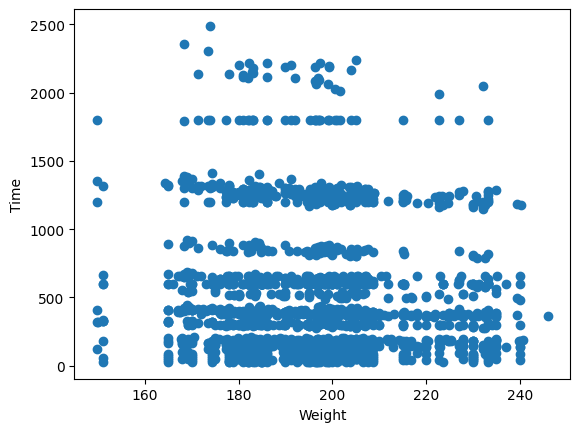 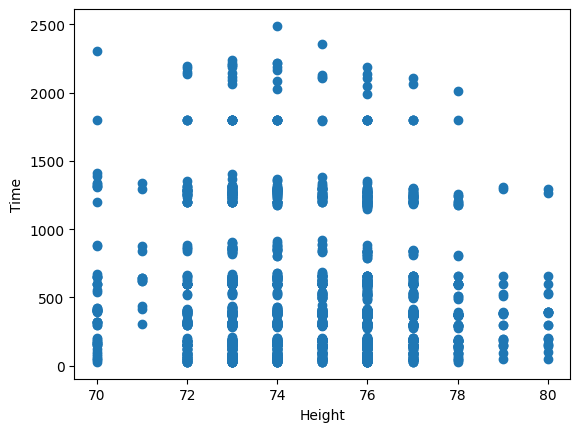

In [197]:
%%capture
#Example code for a binscatterplot
num_bins = 10
bins = np.linspace(df['Height'].min(), df['Height'].max(), num_bins)


df['bin'] = pd.cut(df['Height'], bins=bins, include_lowest=True)
bin_centers = [bin.mid for bin in df['bin'].cat.categories]
bin_means = df.groupby('bin')['Time'].mean()

fig, ax = plt.subplots()
ax.scatter(bin_centers, bin_means, color='blue')  
ax.set_xlabel('Binned Height')
ax.set_ylabel('Average Time')
ax.set_title('Binscatter Plot: Height vs. Time')
plt.show()
df = df.drop('bin', axis = 1)

Here I have created a binscatterplot, this is like a normal scatter plot but instead of plotting every point, the height or distance points are grouped into pieces or "bins". Then the mean of each bin is plotted as a single point. This way you can see the general trend and the chart is more readable. Notice the linearity between height/weight and time?

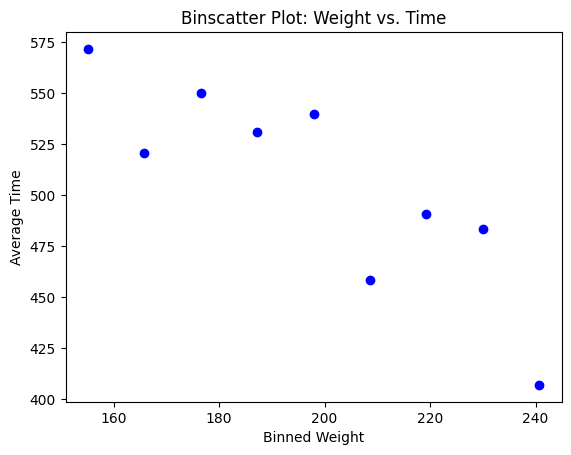 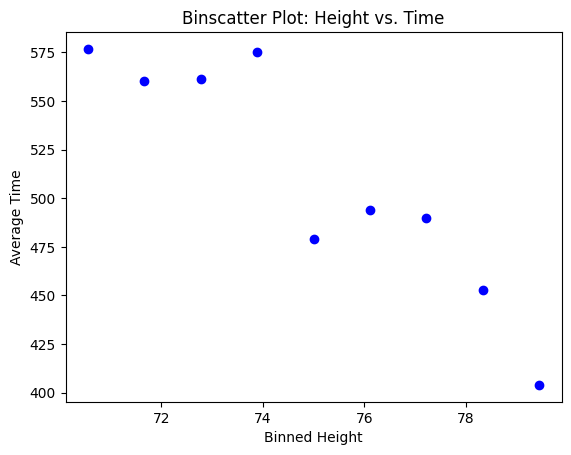

Now lets create a simple test model to create the general function shape and get our data organize. First I will convert our dataframe into a numpy array, divide the first 5 independent variables into one array and the time variable (dependent) into a second array, and create a general framework for our linear regression model using random numbers as coefficients.

In [198]:
dfNP = df.to_numpy()
dfNP.shape

(2052, 6)

In [199]:
xTrain, ytrain = dfNP[:, :5], dfNP[:, -1]
xTrain.shape, ytrain.shape

((2052, 5), (2052,))

In [200]:
def predict(model, X):

    #takes the rows and columns from the xtrain variable from earlier and seperates the rows and columns into variables
    (n, PMinusOne) = X.shape
    p = PMinusOne + 1
    #creates a matrix with n rows (in our case 2052) and p columns (6) and assigns every value to 1
    modX = np.ones(shape=(n, p))
    #filling the last 5 columns with the values of xtrain, leaving the first column as ones
    modX[:, 1:] = X
    #returns the dot multiplication (matrix multiplication) using our inputted test model (this time just random numnbers) and our modified 2d array of values
    return np.dot(modX, model)

#random coefficients I chose to get the function to work
testModel = np.array([0,0.1, 0.3, 1, 1, 0.1])
predict(testModel, xTrain).shape

(2052,)

Now that we have some sample data lets add it to our original frame to show what values the test model returned when using random numbers as coefficients. Below that I added the numeric and percent error between the "predictions" and the actual time. Note that it is way off, almost a 40% difference with the average time being off by 184 seconds.

In [201]:
predictionsFrame = pd.DataFrame({'Height' : df['Height'],
                                 'Weight' : df['Weight'],
                                 'Rate' : df['Rate'],
                                 'Distance' : df['Distance'],
                                 'Time' : df['Time'],   
                                 }) 
predictionsFrame['Test Predictions'] = predict(testModel, xTrain)
predictionsFrame.head()

,Height,Weight,Rate,Distance,Time,Test Predictions
0,75,186.0,32,2000,375.20,427.0
1,77,215.4,24,2000,396.80,448.0
2,74,203.6,32,2000,388.40,443.3
3,78,200.4,32,6000,1183.20,840.8
4,74,206.6,32,482,89.92,294.8


In [202]:
numeric, percent = mean_absolute_error(predictionsFrame['Test Predictions'], ytrain), mean_absolute_percentage_error(predictionsFrame['Test Predictions'], ytrain)
print(f'Numeric Error: {int(numeric)} seconds\nPercent Error: {int(percent * 100)} %')

Numeric Error: 184 seconds
Percent Error: 37 %


Now I will create the actual "model", which is just a short function that impliments the linear regression equation; Y = B0 + B1X1 + B2X2 + ... BpXp + E where X1...Xp are the independent variables, B1...Bp are the coefficients, and E is the error. This will give us the correct coeffients and the predictions for time. In my code I altered it slightly, here is a breakdown of the line beta = np.dot(np.dot(inv(np.dot(xMod.T, xMod)), xMod.T), y):

1. Compute X^T * X:
    This is a matrix multiplication of the transpose of X with X itself. The result is a matrix that represents the sum of squares and cross-products of the predictor variables.
2. Invert X^T * X:
    Calculate the inverse of the matrix X^T * X. This step is crucial for solving the normal equation, as the inverse is used to weigh the influence of each predictor variable in the regression.
3. Multiply by X^T:
    The inverse matrix is then multiplied by the transpose of X again. This prepares the matrix to be applied to the outcome vector y.
4. Multiply by y:
    The resulting matrix from the previous step is multiplied by the vector y (the dependent variable). This final multiplication gives the vector of coefficients beta, which include both the slope and intercept that best fit the linear model to your data.

In [203]:
def getBestModel(X, y):
    #same model as before
    (n, pMinusOne) = X.shape
    p = pMinusOne + 1
    xMod = np.ones(shape=(n,p))
    xMod[:, 1:] = X
    #see markdown above
    beta = np.dot(np.dot(inv(np.dot(xMod.T, xMod)), xMod.T), y)
    return beta

coefficients = getBestModel(xTrain, ytrain)
print("Coefficients: ", coefficients)

Coefficients:  [ 3.02827391e+02 -2.22346268e+00 -2.12220439e+00 -4.48685496e-01
 -1.88288051e+00  2.12725184e-01]


Here is our new results, you can see actual time vs our best predictions. You can see we are still off by 19 seconds and 31% on average. Lets improve that!

In [204]:
maxModel = getBestModel(xTrain, ytrain)
predictionsFrame['Best Predictions'] = predict(maxModel, xTrain)
predictionsFrame.head()

,Height,Weight,Rate,Distance,Time,Test Predictions,Best Predictions
0,75,186.0,32,2000,375.20,427.0,407.199358
1,77,215.4,24,2000,396.80,448.0,408.868532
2,74,203.6,32,2000,388.40,443.3,410.014773
3,78,200.4,32,6000,1183.20,840.8,1251.335248
4,74,206.6,32,482,89.92,294.8,83.629683


In [205]:
numeric, percent = mean_absolute_error(predictionsFrame['Best Predictions'], ytrain), mean_absolute_percentage_error(predictionsFrame['Best Predictions'], ytrain)
print(f'Numeric Error: {int(numeric)} seconds\nPercent Error: {int(percent * 100)} %')

Numeric Error: 19 seconds
Percent Error: 31 %


Now that I did all the math, I can now manipulate and clean our data to achieve better results. The largest problem in a dataset such as these times is that if fails to account for the largest factor, EFFORT. A rower can be very tall and heavy, however if they are sick, exhausted, or simply not trying that will hurt our prediction's accuracy. When assembling the data I removed a few rowers who I knew were sick and injured, however there are still many outliers here. To better understand this data, lets look at the correlation between the independent variables and time.

In [206]:
df.corr()['Time']

Height     -0.081913
Year        0.005742
Weight     -0.052363
Rate       -0.591439
Distance    0.997441
Time        1.000000
Name: Time, dtype: float64

As you can see, the variables with the largest effect are rate, height, and weight. The reason rate is important is as distance increases the rate decreases, which helps the rower use more of their strength rather than cariovascular endurance. Think of this in terms of boxing, where a high rate is like a jab or quick punch, you can do it quickly and with a higher frequency but they will not be as strong and you will tire soon. A lower rate provides more power and a stronger "punch." However, in rowing, you want to balance this as for every second you are not currently pushing water or the handle of the rowing machine, the boat or machine is slowing down, making the next stroke you take harder as you are no longer moving as quickly requiring more force to regain the pace you had. If you are pushing the water or pulling the machine more frequently the machine or boat will not have as much time to slow down. To summarize, the longer the distance the lower the rate will be and vice versa.

Weight and height effect force and leverage respectively. Its the classic equation of force = mass * acceleration. If you can accelerate more mass, your force will be greater. The taller you are the longer your stroke will be and the more leverage you can apply. Both of these will lower the times. 

Year aka years in college seems to have little effect, so lets start by removing this column entirely and rerun our model. I am going to make a quick function to make re-running the model easier:

In [207]:
def parseFrame(df, numColumnsMinOne):
    dfNP = df.to_numpy()
    dfNP.shape
    xTrain, ytrain = dfNP[:, :numColumnsMinOne], dfNP[:, -1]
    xTrain.shape, ytrain.shape
    return xTrain, ytrain

In [208]:
modDF = df.drop('Year', axis = 1)
X, Y = parseFrame(modDF, 4)
maxModel = getBestModel(X, Y)
predictionsFrame = predictionsFrame.drop('Test Predictions', axis = 1)
predictionsFrame = predictionsFrame.drop('Best Predictions', axis = 1)
predictionsFrame['Prediction'] = predict(maxModel, X)
predictionsFrame.head()

,Height,Weight,Rate,Distance,Time,Prediction
0,75,186.0,32,2000,375.20,412.451238
1,77,215.4,24,2000,396.80,407.575740
2,74,203.6,32,2000,388.40,406.615858
3,78,200.4,32,6000,1183.20,1248.658756
4,74,206.6,32,482,89.92,82.218982


In [209]:
numeric, percent = mean_absolute_error(predictionsFrame['Prediction'], Y), mean_absolute_percentage_error(predictionsFrame['Prediction'], Y)
print(f'Numeric Error: {int(numeric)} seconds\nPercent Error: {int(percent * 100)} %')

Numeric Error: 19 seconds
Percent Error: 13 %


By dropping the year column, our error, or average percent margin between actual time and predicted time is now 13%. I will now try and remove data that represents poor effort to see if the model better fits. To do this I am going to break the Time column into quantiles, or percentile groups. I am then going to calculate the IQR or interquartile range, I know my parameters are slightly smaller than quarters but...technicalities. I then use a common statistics measurement to element all values lower than the lower bound and greater than the upper bound, which are determined by subtracting or adding the quantile by the product of 1.5 and the IQR. This should isolate outliers between distance and time, where if your time for a particular distance is outside of these bounds it will not be calculated in the model. These rows are dropped from the frame, and the before and after value of N, or the number of rows, is shown by the before and after shape.

In [210]:
def markOutliers(group):
    Q1 = group['Time'].quantile(0.3)
    Q3 = group['Time'].quantile(0.7)
    IQR = Q3 - Q1
    lowerBound = Q1 - 1.5 * IQR
    upperBound = Q3 + 1.5 * IQR

    mask = (group['Time'] >= lowerBound) & (group['Time'] <= upperBound)
    return mask

print(f'Shape Before: {modDF.shape}')
mask = df.groupby('Distance').apply(markOutliers).reset_index(level=0, drop=True)
modDF = modDF.loc[mask]
modDF.head()
print(f'Shape After: {modDF.shape}')

Shape Before: (2052, 5)
Shape After: (1972, 5)


Now that we removed 80 rows of "bad" data, lets re-run the model:

In [211]:
X, Y = parseFrame(modDF, 4)
maxModel = getBestModel(X, Y)
modDF['Prediction'] = predict(maxModel, X)
numeric, percent = mean_absolute_error(modDF['Prediction'], Y), mean_absolute_percentage_error(modDF['Prediction'], Y)
print(f'Numeric Error: {int(numeric)} seconds\nPercent Error: {int(percent * 100)} %')

Numeric Error: 18 seconds
Percent Error: 17 %


In [212]:
modDF.head()

,Height,Weight,Rate,Distance,Time,Prediction
0,75,186.0,32,2000,375.20,411.330673
1,77,215.4,24,2000,396.80,408.799964
2,74,203.6,32,2000,388.40,407.183810
3,78,200.4,32,6000,1183.20,1246.552079
4,74,206.6,32,482,89.92,83.896763


Our average seconds has become more accurate but our average percent has become first. This indicates that it is become more accurate on shorter distances. To finalize this, I am going to drop rows based on certain conditions. Although this voids most of the data, this is how I have been able to achieve the greatest accuracy:

1. Drop distances less than 1500
2. Drop rowers who weigh more than 215 pounds
3. Drop rowers who weigh less than 160 pounds
4. Drop times greater than 1600 seconds

By doing this the percent error drops to 2.4 percent, the highest achievable with the available data.

In [213]:
modDF = modDF.drop(modDF[modDF.Distance < 1500].index)
modDF = modDF.drop(modDF[modDF.Weight > 215].index)
modDF = modDF.drop(modDF[modDF.Weight < 160].index)
modDF = modDF.drop(modDF[modDF.Time > 1600].index)

In [214]:
modDF = modDF.drop('Prediction', axis=1)
X, Y = parseFrame(modDF, 4)
maxModel = getBestModel(X, Y)
modDF['Prediction'] = predict(maxModel, X)
numeric, percent = mean_absolute_error(modDF['Prediction'], Y), mean_absolute_percentage_error(modDF['Prediction'], Y)
print(f'Numeric Error: {float(numeric)} seconds\nPercent Error: {float(percent * 100)} %')

Numeric Error: 15.796528161630496 seconds
Percent Error: 2.444044674864338 %


In conclusion, by attempting to remove areas where anomalies and outliers lay, we can achieve 2.4% error. In all honesty, the main reason this is flawed is I did not account for quantity of pieces, which will greatly impact the accuracy negatively.